In [1]:
from tqdm import tqdm
import pandas as pd
import cv2 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pickle as pkl
from Levenshtein import distance as levenstein

import mnist_converter
import image_shower
import context_transform
import image_transformations
import mnist_converter
import Levenshtein

np.warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
path_mnist = 'data/MNIST/'
conf_test_mnist = {
    'imgf': path_mnist+'t10k-images.idx3-ubyte',
    'labelf': path_mnist+'t10k-labels.idx1-ubyte',
    'n': 10000,
    'outf': path_mnist+'mnist_test.csv',
    'size': (28, 28)
}
conf_train_mnist = {
    'imgf': path_mnist+'train-images.idx3-ubyte',
    'labelf': path_mnist+'train-labels.idx1-ubyte',
    'n': 60000,
    'outf': path_mnist+'mnist_train.csv',
    'size': (28, 28)
}

In [5]:
df = pd.read_csv(conf_train_mnist['outf'], header=None)
df_test = pd.read_csv(conf_test_mnist['outf'], header=None)

In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
# TODO: CUPY
# TODO: Правило Ойо не сходится по непонятным причинам

class Cluster:
    """
    Кластер в точке комбинаторного пространства
    
    base_in_subvector, base_out_subvector - бинарный код, образующий кластер. Между образующим кодом и новым кодом
    будет вычисляться скалярное произведение
    in_threshold_modify, out_threshold_modify - порог активации кластера 
    in_threshold_bin, out_threshold_bin - порог бинаризации кода
    вектора на новый вектор больше порога, то будет пересчитан веса кластера, выделяющие первую главную компоненту
    base_lr - начальное значение скорости обучения
    is_modify_lr - модификация скорости обучения пропорционально номер шага
    """   
    def __init__(self, 
                 base_in, base_out,
                 in_threshold_modify, out_threshold_modify,
                 in_threshold_bin, out_threshold_bin,
                 base_lr=0.5,
                 is_modify_lr=True):
        self.in_threshold_modify, self.out_threshold_modify = in_threshold_modify, out_threshold_modify
        self.base_lr = base_lr
        
        # Первые главные компоненты для входного и выходного векторов (Согласно правилу Хебба)
        self.in_w, self.out_w = base_in, base_out
        
        self.in_threshold_bin, self.out_threshold_bin = in_threshold_bin, out_threshold_bin
        self.is_modify_lr = is_modify_lr
        self.count_modifing = 0
        
    """
    Предсказание вперёд, т.е. предсказание входа по выходу
    
    in_x - входной вектор
    
    Возвращается значение похожести (корелляция), предсказанный вектор соответствующего размера
    """  
    def predict_front(self, in_x): 
        corr = np.corrcoef(in_x, self.in_w)[0, 1]
        if corr > self.in_threshold_modify:
            return corr, np.uint8(self.out_w > self.out_threshold_bin)
        
    """
    Предсказание назад, т.е. предсказание выхода по входу
    
    out_x - выходной вектор
    
    Возвращается значение похожести (корелляция), предсказанный вектор соответствующего размера
    """
    def predict_back(self, out_x): 
        corr = np.corrcoef(out_x, self.out_w)[0, 1]
        if corr > self.out_threshold_modify:
            return corr, np.uint8(self.in_w > self.in_threshold_bin)
        
        
    """
    Функция, производящая модификацию пары кодов кластера точки комбинаторного пространства
    
    in_x, out_x - входной и выходной бинарные векторы подкодов соответствующих размерностей
    
    Возвращается 1, если была произведена модификация весов (т.е. кластер был активирован). В противном случае
    возвращается 0
    """
    def modify(self, in_x, out_x):
        in_y = np.dot(in_x, self.in_w)
        out_y = np.dot(out_x, self.out_w)
        out_corr = np.corrcoef(out_x, self.out_w)[0, 1]
        in_corr = np.corrcoef(out_x, self.out_w)[0, 1]
        
        if in_corr > self.in_threshold_modify and \
            out_corr > self.out_threshold_modify:
                self.count_modifing += 1
                if self.is_modify_lr:
                    delta_in = np.array((self.base_lr/self.count_modifing)*in_y*in_x)
                    delta_out = np.array((self.base_lr/self.count_modifing)*out_y*out_x)
                    # Правило Ойо почему-то расходится
#                   self.in_w = self.in_w + (self.base_lr/self.count_modifing)*in_y*(in_x - in_y*self.in_w)
#                   self.out_w = self.out_w + (self.base_lr/self.count_modifing)*out_y*(out_x - out_y*self.out_w)
                else:
                    delta_in = np.array(self.base_lr*in_y*in_x)
                    delta_out = np.array(self.base_lr*out_y*out_x)
                    # Правило Ойо почему-то расходится
#                   self.in_w = self.in_w + (self.base_lr*in_y*(in_x - in_y*self.in_w)
#                   self.out_w = self.out_w + (self.base_lr*out_y*(out_x - out_y*self.out_w)
                self.in_w = np.divide((self.in_w + delta_in), (np.sum(self.in_w**2)**(0.5)))
                self.out_w = np.divide((self.out_w + delta_out), (np.sum(self.out_w**2)**(0.5)))

                return 1
        return 0
                
        
class Point:
    """
    Точка комбинаторного пространства. Каждая точка содержит набор кластеров
    
    in_threshold_modify, out_threshold_modify - порог активации кластера. Если скалярное произведение базового 
    вектора кластера на новый вектор больше порога, то будет пересчитан веса кластера, выделяющие первую главную
    компоненту
    in_threshold_activate, out_threshold_activate - порог активации точки комбинаторного пространства. Если кол-во
    активных битов больше порога, то будет инициирован процесс модификации существующих кластеров, а также будет
    добавлен новый кластер
    in_threshold_bin, out_threshold_bin - порог бинаризации кода
    count_in_demensions, count_out_demensions - размер входного и выходного векторов в точке комб. пространства
    in_size, out_size - количество случайных битов входного/выходного вектора
    base_lr - начальное значение скорости обучения
    is_modify_lr - модификация скорости обучения пропорционально номер шага
    max_cluster_per_point - максимальное количество кластеров в точке
    """    
    def __init__(self,
                 in_threshold_modify, out_threshold_modify,
                 in_threshold_activate, out_threshold_activate,
                 in_threshold_bin, out_threshold_bin,
                 in_size, out_size,
                 count_in_demensions, count_out_demensions,
                 base_lr, is_modify_lr,
                 max_cluster_per_point):
        self.in_coords = np.random.random_integers(0, in_size-1, count_in_demensions)
        self.out_coords = np.random.random_integers(0, out_size-1, count_out_demensions)
        self.count_in_demensions, self.count_out_demensions = count_in_demensions, count_out_demensions
        self.clusters = []
        self.in_threshold_modify, self.out_threshold_modify = in_threshold_modify, out_threshold_modify
        self.in_threshold_activate, self.out_threshold_activate = in_threshold_activate, out_threshold_activate
        self.in_threshold_bin, self.out_threshold_bin = in_threshold_bin, out_threshold_bin
        self.base_lr = base_lr
        self.is_modify_lr = is_modify_lr
        self.max_cluster_per_point = max_cluster_per_point        
    
    """
    Осуществление выбора оптимального кластера при прямом предсказании 
    
    in_code - входной вектор 
    type_code - тип возвращаемого кода (с -1 или с 0)
    
    Возвращается оптимальный выходной вектор
    """
    def predict_front(self, in_code, type_code=-1):
        in_x = np.array(in_code)[self.in_coords]
        is_active = np.sum(in_x) > self.in_threshold_activate
        opt_corr = -np.inf
        opt_out_code = None
        if is_active:
            for cluster in self.clusters:
                corr, out_x = cluster.predict_front(in_x)
                if corr > opt_corr:
                    opt_corr = corr
                    opt_out_code = np.array([0] * self.count_out_demensions)
                    if type_code == -1:
                        out_x[out_x == 0] = -1
                    opt_out_code[self.out_coords] = out_x
        return opt_out_x
    
    """
    Осуществление выбора оптимального кластера при обратном предсказании 
    
    out_code - выходной вектор
    type_code - тип возвращаемого кода (с -1 или с 0)
    
    Возвращается оптимальный входной вектор
    """
    def predict_back(self, out_code):
        out_x = np.array(out_code)[self.out_coords]
        is_active = np.sum(out_x) > self.out_threshold_activate
        opt_corr = -np.inf
        opt_in_code = None
        if is_active:
            for cluster in self.clusters:
                corr, in_x = cluster.predict_back(out_x)
                if corr > opt_corr:
                    opt_corr = corr
                    opt_in_code = np.array([0] * self.count_in_demensions)
                    if type_code == -1:
                        in_x[in_x == 0] = -1
                    opt_in_code[self.in_coords] = in_x
        return opt_in_code
    
    """
    Функция, производящая добавление пары кодов в каждый кластер точки комбинаторного пространства
    
    in_code, out_code - входной и выходной бинарные векторы кодов соответствующих размерностей
    
    Возвращается количество произведённых модификаций внутри кластеров точки, флаг добавления кластера
    (True - добавлен, False - не добавлен)
    """
    def add(self, in_code, out_code=None):
        in_x = np.array(in_code)[self.in_coords]
        out_x = np.array(out_code)[self.out_coords]
        count_modify = 0
        count_fails = 0
        
        # Возможно, проверять активацию не нужно, поскольку это будет отсекаться по скалярному произведению
        # при подсчёте корелляции
        is_active = np.sum(in_x) > self.in_threshold_activate and \
                    np.sum(out_x) > self.out_threshold_activate
        if len(self.clusters) < self.max_cluster_per_point
            if is_active:
                for cluster in self.clusters:
                    if cluster.modify(in_x, out_x):
                        count_modify += 1
                    else:
                        count_fails += 1
                return count_fails, count_modify, False
            else:
                self.clusters.append(
                    Cluster(
                        base_in_subvector=in_x,
                        base_out_subvector=out_x,
                        in_threshold_modify=self.in_threshold_modify, 
                        out_threshold_modify=self.out_threshold_modify,
                        base_lr=self.base_lr, is_modify_lr=self.is_modify_lr
                    )
                )
                return count_fails, count_modify, True
        return count_fails, count_modify, False
                

class Minicolumn:
    """
    Миниколонка. Миниколонка - это набор точек комбинаторного пространства
    
    space_size - количество точек комбинаторного пространства
    max_cluster_per_point - максимальное количество кластеров в точке
    max_count_clusters - максмальное суммарное количество кластеров по всем точкам комбинаторного пространства
    in_threshold_modify, out_threshold_modify - порог активации кластера. Если скалярное произведение базового 
    вектора кластера на новый вектор больше порога, то будет пересчитан веса кластера, выделяющие первую главную
    компоненту
    in_threshold_activate, out_threshold_activate - порог активации точки комбинаторного пространства. Если кол-во
    активных битов больше порога, то будет инициирован процесс модификации существующих кластеров, а также будет
    добавлен новый кластер
    in_size, out_size - количество случайных битов входного/выходного вектора
    base_lr - начальное значение скорости обучения
    is_modify_lr - модификация скорости обучения пропорционально номер шага
    count_in_demensions, count_out_demensions - размер входного и выходного векторов в точке комб. пространства
    threshold_bits_controversy - порог противоречия для битов кодов
    out_non_zero_bits - число ненулевых бит в выходном векторе
    """
    
    def __init__(self, space_size=60000, max_cluster_per_point=100,
                 max_count_clusters=1000000, seed=42, 
                 in_threshold_modify=5, out_threshold_modify=0, 
                 in_threshold_activate=5, out_threshold_activate=0,
                 in_size=256, out_size=16,
                 base_lr=0.01, is_modify_lr=True,
                 count_in_demensions=24, count_out_demensions=10,
                 threshold_controversy=0.1,
                 out_non_zero_bits=6):
        self.space = np.array(
            [
                Point(
                    in_threshold_modify, out_threshold_modify,
                    in_threshold_activate, out_threshold_activate,
                    count_in_demensions, count_out_demensions,
                    in_size, out_size,
                    base_lr, is_modify_lr,
                    max_cluster_per_point
                ) for _ in range(space_size)
            ]
        )
        self.count_clusters = 0
        self.max_count_clusters = max_count_clusters
        self.count_in_demensions, self.count_out_demensions = count_in_demensions, count_out_demensions
        self.threshold_bits_controversy = threshold_bits_controversy
        self.out_non_zero_bits = out_non_zero_bits
        
        np.random.seed(seed)
        
    """
    Получение выходного кода по входному. Прямое предсказание в каждой точке комбинаторного пространства
    
    in_code - входной код
    
    Возвращаемые значения: непротиворечивость, выходной код
    """
    def front_predict(self, in_code):
        out_code = [0] * self.count_out_demensions
        count = [0] * self.count_out_demensions
        for point in self.space:
            __out_code = point.predict_front(in_code, -1)
            
            # Неактивная точка
            if __out_code is None:
                continue
                
            __count = np.uint8(__out_code != 0)
            count += __count
            out_code += __out_code
        if np.sum(count == np.nan):
            raise ValueError("Не все биты входного вектора учитываются")
        controversy = np.sum(np.abs(out_code / count) < self.threshold_controversy)
        out_code[out_code <= 0] = 0
        out_code[out_code > 0] = 1
        return controversy, out_code
    
    """
    Получение входного кода по выходному. Обратное предсказание в каждой точке комбинаторного пространства
    
    out_code - выходной код
    
    Возвращаемые значения: непротиворечивость, входной код
    """
    def back_predict(self, out_code):
        in_code = [0] * self.count_in_demensions
        count = [0] * self.count_in_demensions
        for point in self.space:
            __in_code = point.predict_back(out_code, -1)
            
            # Неактивная точка
            if __in_code is None:
                continue
            
            __count = np.uint8(__in_code != 0)
            count += __count
            in_code += __in_code
        if np.sum(count == np.nan):
            raise ValueError("Не все биты выходного вектора учитываются")
        controversy = np.sum(np.abs(in_code / count) < self.threshold_controversy)
        in_code[in_code <= 0] = 0
        in_code[in_code > 0] = 1
        return controversy, in_code
        
    """
    Этап сна
    
    threshold_active - порог активности бита внутри кластера (вес в преобразовании к первой главной компоненте), 
    выше которого активность остаётся
    threshold_in_len, threshold_out_len - порог количества ненулевых битов
    """    
    def sleep(self, threshold_active=0.75, threshold_in_len=4, threshold_out_len=0):
        clusters_of_points = []
        the_same_clusters = 0
        for point_ind, point in enumerate(self.space):
            clusters_of_points.append([])
            active_clusters = []
            for cluster_ind, cluster in enumerate(point.clusters):
                in_active_mask = np.abs(cluster.in_w) > threshold_active
                out_active_mask = np.abs(cluster.out_w) > threshold_active
                
                if len(cluster.in_w[in_active_mask]) > threshold_in_len and \
                    len(cluster.out_w[out_active_mask]) > threshold_out_len:
                        
                    # Подрезаем кластер
                    cluster.base_in_subvector[~in_active_mask] = 0
                    cluster.base_out_subvector[~out_active_mask] = 0
                    
                    active_clusters.append(cluster)
                    clusters_of_points[-1].append(cluster_ind)
                else:
                    minicolumn.count_clusters -= 1
                    
            # Удаляем одинаковые кластеры (те кластеры, у которых одинаковые базовые векторы)
            point.clusters = []
            for cluster_i in range(len(active_clusters)):
                is_exist_the_same = False
                for cluster_j in range(cluster_i+1, len(active_clusters)):
                    if np.sum(np.uint8(active_clusters[cluster_i].base_in_subvector == \
                        active_clusters[cluster_j].base_in_subvector)) \
                        and \
                        np.sum(np.uint8(active_clusters[cluster_i].base_out_subvector == \
                        active_clusters[cluster_j].base_out_subvector)):
                            is_exist_the_same = True
                            continue
                if not is_exist_the_same:
                    point.clusters.append(active_clusters[cluster_i])
                else:
                    the_same_clusters += 1
                    self.count_clusters -= 1
            
        return clusters_of_points, the_same_clusters
        
    """
    Проверям: пора ли спать
    """
    def is_sleep(self):
        return self.count_clusters > self.max_count_clusters
    
    def code_alignment(self, code):
        if count_active_bits > self.out_non_zero_bits:
            active_bits = np.where(code == 1)
            count_active_bits = active_bits.shape[0]
            stay_numbers = np.random.choice(
                count_active_bits, self.out_non_zero_bits, replace=False
            )
            active_bits = active_bits[stay_numbers]
            code_mod = np.zeros(code.shape[0])
            code_mod[active_bits] = 1
        elif count_active_bits < self.out_non_zero_bits:
            non_active_bits = np.where(code == 0)
            count_non_active_bits = non_active_bits.shape[0]
            count_active_bits = code.shape[0] - count_non_active_bits
            stay_numbers = np.random.choice(
                count_non_active_bits, self.out_non_zero_bits - count_active_bits, replace=False
            )
            non_active_bits = non_active_bits[stay_numbers]
            code_mod[non_active_bits] = 1
        return code_mod
        
    
    """
    Этап обучения без учителя
    
    Делается предсказание для всех переданных кодов и выбирается самый непротиворечивый из них, 
    либо констатируется, что такого нет.
    
    Для каждой активной точки выбирается наиболее подходящий кластер. Его предсказание учитывается в качестве
    ответа. Для конкретной точки все остальные кластеры учтены не будут.
    
    В качестве результата непротиворечивости берём среднее значение по ответам делёное на число активных точек.
    
    in_codes - входные коды в разных контекстах
    threshold_controversy_in, threshold_controversy_out - порого противоречивости для кодов
    
    Возвращается оптимальный код, порядковый номер контекста-победителя, 
    количество фэйлов во входном и выходном векторах
    """
    def unsupervised_learning(self, in_codes, threshold_controversy_in, threshold_controversy_out):
                       
        min_hamming = np.inf
        min_ind_hamming = -1
        min_out_code = None
        out_fail = 0
        in_fail = 0
        for index in len(in_codes):
            
            controversy_out, out_code = self.front_predict(in_codes[index].flatten())
            
            if controversy_out > threshold_controversy_out:
                out_fail += 1
                continue
                
            # Удаляем или добавляем единицы (если их мало или много)
            out_code = self.code_alignment(out_code)
            
            controversy_in, in_code = self.back_predict(out_code)
            
            if controversy_in > threshold_controversy_in:
                in_fail += 1
                continue
                
            
            hamming_dist = Levenstein.hamming(''.join(map(str, in_code)), ''.join(map(str, in_codes[index])))
            if min_hamming < hamming_dist:
                min_hamming = hamming_dist
                min_ind_hamming = index
                min_out_code = out_code
            
        return min_out_code, min_ind_hamming, in_fail, out_fail
    
    """
    Этап обучения без учителя
    
    Делается предсказание для всех переданных кодов и выбирается самый непротиворечивый из них, 
    либо констатируется, что такого нет.
    
    Для каждой активной точки выбирается наиболее подходящий кластер. Его предсказание учитывается в качестве
    ответа. Для конкретной точки все остальные кластеры учтены не будут.
    
    В качестве результата непротиворечивости берём среднее значение по ответам делёное на число активных точек.
    
    codes - входные коды в разных контекстах
    
    Возвращается ...
    """
    def supervised_learning(self, in_codes, out_codes):
                       
        min_hamming = np.inf
        min_ind_hamming = -1
        min_out_code = None
        out_fail = 0
        in_fail = 0
        for index in len(in_codes):
            
            controversy_out, out_code = self.front_predict(in_codes[index].flatten())
            
            if controversy_out > threshold_controversy_out:
                out_fail += 1
                continue                
            
            hamming_dist = Levenstein.hamming(''.join(map(str, out_code)), ''.join(map(str, out_codes[index])))
            if min_hamming < hamming_dist:
                min_hamming = hamming_dist
                min_ind_hamming = index
                min_out_code = out_code
            
        return min_out_code, min_ind_hamming, in_fail, out_fail
    
    
    """
    Этап обучения с учителем
    
    Создание и модификация кластеров на основе пары кодов: входной и выходной
    
    in_code, out_code - входной и выходной коды
    
    Возвращается количество точек, которые оказались неактивными; количество модификаций кластеров;
    количество новых кластеров
    """
    def learn(self, in_code, out_code=None):
        if self.is_sleep():
            return None, None, None
        
        if out_code is not None:
            in_code, out_code = self.supervised_learning(in_codes, out_codes)
        else:
            in_code, out_code = self.unsupervised_learning(in_codes)
            
        
        count_fails = 0
        count_modify = 0
        count_adding = 0
        
        for point in self.space:
            __count_fails, __count_modify, __count_adding = point.add(in_code, out_code)
            count_modify += __count_modify
            count_fails += __count_fails
            count_adding += __count_adding
            self.count_clusters += np.uint(__count_adding)
        return count_fails, count_modify, count_adding

SyntaxError: invalid syntax (<ipython-input-2-b79242e5bb41>, line 193)

# Пример обучения с учителем

In [8]:
max_number = 5000
count_subimages_for_image = 7
window_size = [4, 4]
minicolumn = Minicolumn(max_count_clusters=200000)
for image_number in range(max_number):
    label, image = image_transformations.get_image(df, image_number)
    for subimage_number in range(0, 7):
        x, y = np.random.random_integers(0, 27-window_size[0], 2)
        image_sample = image[y:y+window_size[0], x:x+window_size[1]]
        
        if np.sum(np.sum(image_sample)) == 0:
            continue
            
        codes = context_transform.get_shift_context(image_sample)
        count_fails, count_modify, count_adding = minicolumn.learn(codes)
        if count_fails is not None:
            print(
                'Изменения:', int(count_modify),
                '. Пропуски:', int(count_fails),
                '. Новые кластеры:', int(count_adding),
                '. Всего кластеров:', int(minicolumn.count_clusters)
            )
        else:
            print('Сон')
            clusters_of_points, the_same_clusters = minicolumn.sleep()
            sum_ = 0
            for ind, cluster in enumerate(clusters_of_points):
                if len(cluster) == 0:
                    sum_ += 1
            print(
                'Неактивные точки:', sum_,
                '. Одинаковые кластеры:', the_same_clusters
            )

Изменения: 0 . Пропуски: 0 . Новые кластера: 0 . Всего кластеров: 0
Изменения: 0 . Пропуски: 0 . Новые кластера: 0 . Всего кластеров: 0
Изменения: 0 . Пропуски: 0 . Новые кластера: 0 . Всего кластеров: 0
Изменения: 0 . Пропуски: 0 . Новые кластера: 0 . Всего кластеров: 0
Изменения: 0 . Пропуски: 0 . Новые кластера: 0 . Всего кластеров: 0
Изменения: 0 . Пропуски: 0 . Новые кластера: 39127 . Всего кластеров: 39127
Изменения: 0 . Пропуски: 0 . Новые кластера: 0 . Всего кластеров: 39127
Изменения: 0 . Пропуски: 23482 . Новые кластера: 37215 . Всего кластеров: 76342
Изменения: 0 . Пропуски: 0 . Новые кластера: 0 . Всего кластеров: 76342
Изменения: 0 . Пропуски: 0 . Новые кластера: 0 . Всего кластеров: 76342
Изменения: 0 . Пропуски: 0 . Новые кластера: 0 . Всего кластеров: 76342
Изменения: 0 . Пропуски: 61774 . Новые кластера: 38929 . Всего кластеров: 115271
Изменения: 76144 . Пропуски: 24559 . Новые кластера: 38929 . Всего кластеров: 154200
Изменения: 115073 . Пропуски: 24559 . Новые класте

Изменения: 0 . Пропуски: 0 . Новые кластера: 0 . Всего кластеров: 60000
Изменения: 0 . Пропуски: 0 . Новые кластера: 0 . Всего кластеров: 60000
Изменения: 0 . Пропуски: 0 . Новые кластера: 0 . Всего кластеров: 60000
Изменения: 2 . Пропуски: 39058 . Новые кластера: 39060 . Всего кластеров: 99060
Изменения: 0 . Пропуски: 0 . Новые кластера: 0 . Всего кластеров: 99060
Изменения: 0 . Пропуски: 0 . Новые кластера: 0 . Всего кластеров: 99060
Изменения: 39062 . Пропуски: 39058 . Новые кластера: 39060 . Всего кластеров: 138120
Изменения: 0 . Пропуски: 0 . Новые кластера: 0 . Всего кластеров: 138120
Изменения: 0 . Пропуски: 0 . Новые кластера: 0 . Всего кластеров: 138120
Изменения: 0 . Пропуски: 0 . Новые кластера: 0 . Всего кластеров: 138120
Изменения: 0 . Пропуски: 0 . Новые кластера: 0 . Всего кластеров: 138120
Изменения: 0 . Пропуски: 0 . Новые кластера: 0 . Всего кластеров: 138120
Изменения: 0 . Пропуски: 0 . Новые кластера: 0 . Всего кластеров: 138120
Изменения: 0 . Пропуски: 0 . Новые кл

KeyboardInterrupt: 

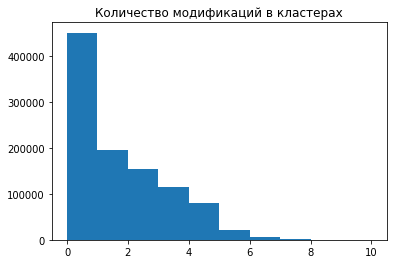

In [33]:
modifing_counts = []
for point in minicolumn.space:
    for cluster in point.clusters:
        modifing_counts.append(cluster.count_modifing)
plt.hist(modifing_counts, bins=10)
plt.title('Количество модификаций в кластерах');

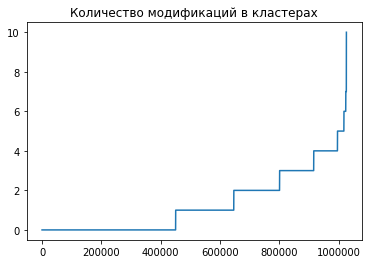

In [31]:
modifing_counts = sorted(modifing_counts)
plt.plot(range(len(modifing_counts)), modifing_counts)
plt.title('Количество модификаций в кластерах');

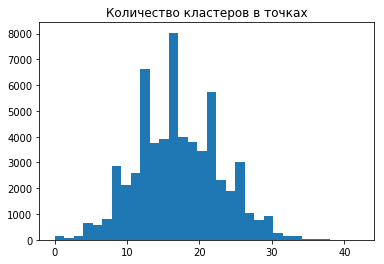

In [19]:
clusters_size = []
for point in minicolumn.space:
    clusters_size.append(len(point.clusters))
plt.hist(clusters_size, bins=2*16)
plt.title('Количество кластеров в точках');

In [ ]:
clusters_size = []
for point in minicolumn.space:
    clusters_size.append(len(point.clusters))
plt.hist(clusters_size, bins=2*16)
plt.title('Количество кластеров в точках');

In [41]:
sub_set = df.loc[:, 0] < 5
neurons = 50

In [ ]:
mlp_alpha = []
for alpha in np.arange(0, 360, 10):
    df_rotate = df.apply(lambda row: rotate_row_data_frame(row, alpha=alpha, scale=1), axis=1)
    mlp_alpha.append(MLPRegressor(hidden_layer_sizes=(neurons,), random_state=42))
    sub_set = df.loc[:, 0] < 5
    mlp_alpha[-1].fit(df_rotate.loc[sub_set, 1:], df.loc[sub_set, 1:])

In [ ]:
mlp_scale = []
for alpha in np.arange(0.5, 1.5, 0.05):
    df_scaled = df.apply(lambda row: rotate_row_data_frame(row, alpha=0, scale=1.5), axis=1)
    mlp_scale.append(MLPRegressor(hidden_layer_sizes=(neurons,), random_state=42))
    mlp_scale[-1].fit(df_scaled.loc[sub_set, 1:], df.loc[sub_set, 1:])

In [138]:
with open('data/models.pkl', 'wb') as f:
    pkl.dump({'scale': mlp_scale, 'rotate': mlp_alpha}, f)

In [92]:
mean_squared_error(df.loc[~sub_set, 1:], mlp_scale[-1].predict(df_rotate.loc[~sub_set, 1:]))

1344.4169540898924

In [101]:
y_pred = mlp_scale[-1].predict(df_rotate.loc[~sub_set, 1:])

In [102]:
df_test = df.iloc[np.where(~sub_set)]
df_rotate_test = df_rotate.iloc[np.where(~sub_set)]

In [43]:
ind = 800

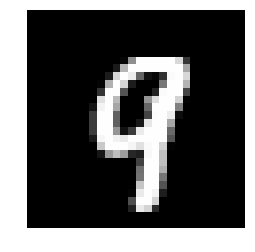

In [46]:
plt.imshow(df_test.iloc[ind, 1:].values.reshape((28, 28)).astype(np.uint8), cmap='gray');
plt.axis('off');

In [ ]:
plt.imshow(df_rotate_test.iloc[ind, 1:].values.reshape((28, 28)).astype(np.uint8), cmap='gray');
plt.axis('off');

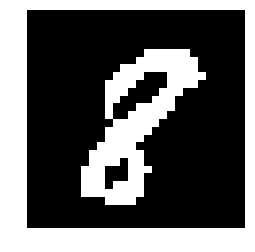

In [129]:
tmp = np.uint((y_pred[ind] - np.min(y_pred[ind])) / (np.max(y_pred[ind]) - np.min(y_pred[ind])) > 0.5)
plt.imshow(tmp.reshape((28, 28)).astype(np.uint8), cmap='gray');
plt.axis('off');